# Setup and Load Data

### Install dependencies and setup

In [ ]:
! pip install tensorflow opencv-python matplotlib

In [ ]:
!pip install protobuf==3.20.3

In [1]:
import tensorflow as tf
import os

In [2]:
os.path.join("data", "happy")

'data\\happy'

In [3]:
os.listdir("data")

['happy', 'sad']

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[]

# Remove dodgy images

In [27]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [34]:
data_dir = 'data'
image_extensions = ['jpg', 'jpeg', 'png', 'bmp']

In [35]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

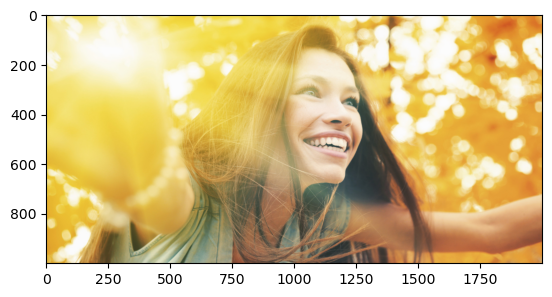

In [33]:
# Example photo
img = cv2.imread(os.path.join(data_dir, "happy", "o-HAPPY-facebook.jpg"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Load Data

In [37]:
tf.data.Dataset??

In [38]:
import numpy as np

In [39]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 171 files belonging to 2 classes.


In [42]:
data_iterator = data.as_numpy_iterator()

In [51]:
# Get another bacth from the iterator
batch = data_iterator.next()

In [52]:
batch[0].shape

(32, 256, 256, 3)

In [53]:
batch[1]

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1])

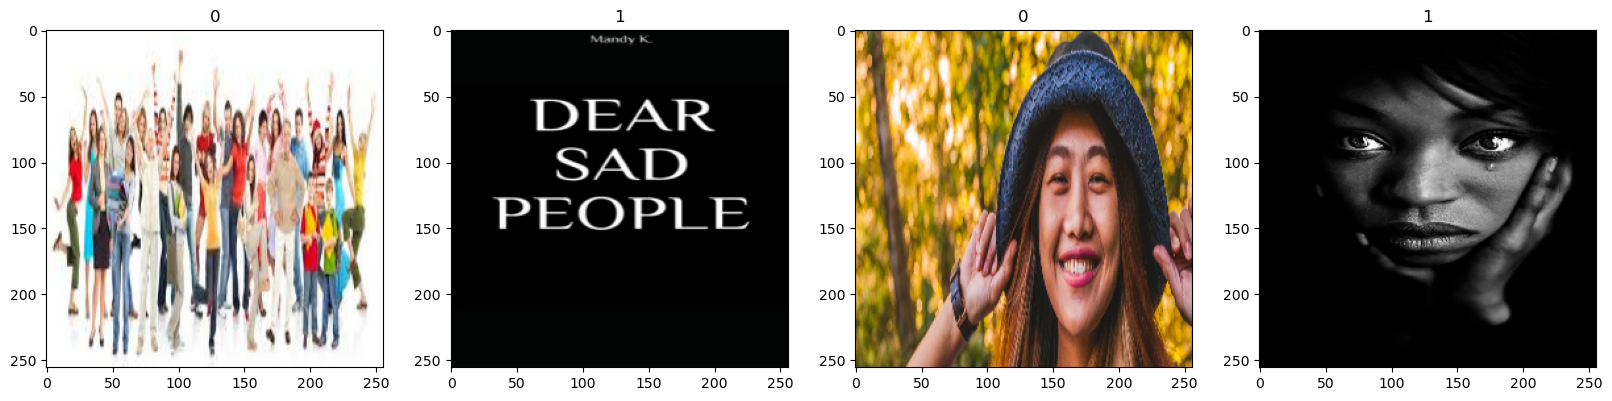

In [56]:
# Class 1 = sad
# Class 0 = happy

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocess data

In [60]:
data = data.map(lambda x, y: (x/255, y))

### Split data

In [63]:
len(data)

6

In [66]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [67]:
print(train_size)
print(val_size)
print(test_size)

4
1
1


In [68]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [69]:
len(train)

4

# Deep Learning Model

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [72]:
model = Sequential()

In [73]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [75]:
model.compile("adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

### Training

In [76]:
logdir = 'logs'

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [78]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 16s 3s/step - loss: 0.8325 - accuracy: 0.5312 - val_loss: 0.6961 - val_accuracy: 0.4062
Epoch 2/20
4/4 [==============================] - 15s 3s/step - loss: 0.6747 - accuracy: 0.5156 - val_loss: 0.6435 - val_accuracy: 0.5312
Epoch 3/20
4/4 [==============================] - 13s 3s/step - loss: 0.5703 - accuracy: 0.6406 - val_loss: 0.5874 - val_accuracy: 0.5625
Epoch 4/20
4/4 [==============================] - 15s 3s/step - loss: 0.5319 - accuracy: 0.6953 - val_loss: 0.4315 - val_accuracy: 0.8125
Epoch 5/20
4/4 [==============================] - 14s 3s/step - loss: 0.4748 - accuracy: 0.7422 - val_loss: 0.5275 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 14s 3s/step - loss: 0.4150 - accuracy: 0.8125 - val_loss: 0.2681 - val_accuracy: 0.9062
Epoch 7/20
4/4 [==============================] - 13s 3s/step - loss: 0.2953 - accuracy: 0.8984 - val_loss: 0.2469 - val_accuracy: 0.8750
Epoch 8/20
4/4 [==================

### Plot performance

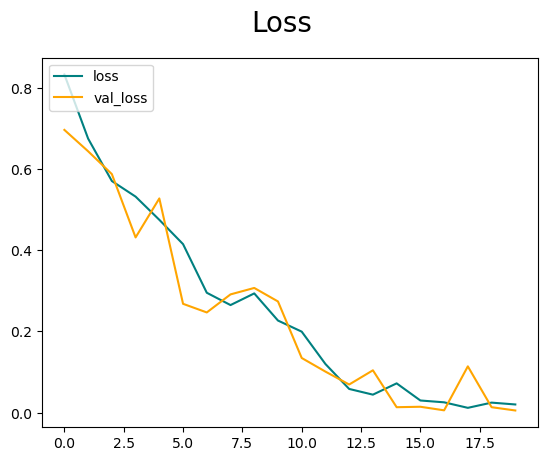

In [81]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

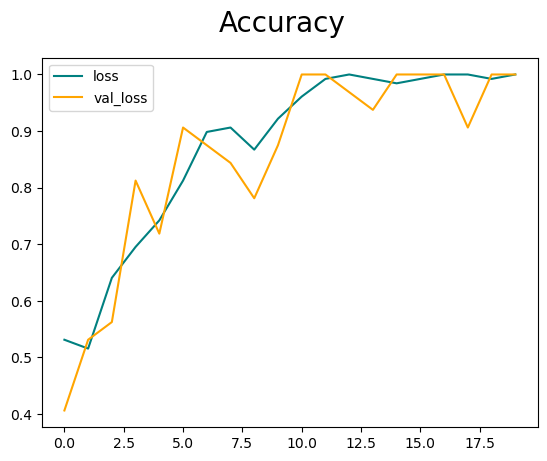

In [82]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluating Performance

In [83]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [87]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [88]:
len(test)

1

In [90]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 200ms/step


In [92]:
print(f"Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}")

Precision:1.0, Recall:1.0, Accuracy:1.0


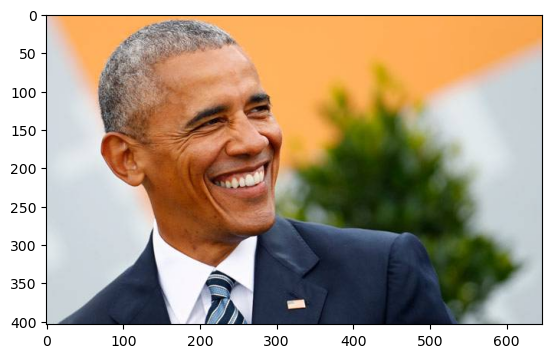

In [119]:
img = cv2.imread("data\\happy_obama.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

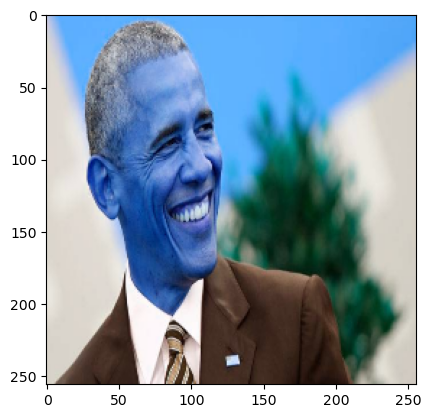

In [120]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [121]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 48ms/step


In [122]:
if yhat > 0.5:
    print("Predicted class is sad")
else:
    print("Predicted class is happy")

Predicted class is happy


In [123]:
yhat

array([[0.3221127]], dtype=float32)

# Save the model

In [125]:
from tensorflow.keras.models import load_model

In [126]:
model.save(os.path.join('models', 'happy_sad_classification_v1.h5'))

### Load Model

In [127]:
new_model = load_model(os.path.join('models', 'happy_sad_classification_v1.h5'))